# Overview
This notebook contains a pipeline for a **PyTorch DNN** to **predict stock movements** for the **Optiver Trading Challenge**.
- Customizable Neural Network
- Preprocessing and Normalization of Input Data
- Feature Engineering
- Decaying Learning Rate and Early Stopping
- Hardware Acceleration

## Possible Improvements
- [PyTorch Profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html) for Bottlenecks
- Hyperparameter Tuning with [RayTune](https://docs.ray.io/en/latest/tune/index.html) (lr, layers, batchsize)
- Flag filled NaN for near_price and far_price
- Regularisation methods for deeper networks (batchnorm)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
plt.tight_layout()
plt.rcParams['figure.figsize'] = (6, 3)
%matplotlib inline
import warnings
# warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

<Figure size 640x480 with 0 Axes>

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from fastai.tabular.all import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Data

In [4]:
df_raw = pd.read_csv('../input/optiver-trading-at-the-close/train.csv')
# df_test = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/test.csv')
# sample_sub = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
# rev_target = pd.read_csv('../input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

df_raw.isna().sum(axis=0) / len(df_raw)
df_raw

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [5]:
df_raw.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [6]:
def add_historic_features(df, cols, shifts=3, add_first=True):
    for col in cols:
        grouped_vals = df[["stock_id", "date_id", col]].groupby(["stock_id","date_id"])
        fill_value = df[col].mean()
        
        for shift in np.arange(shifts):
#             print(type(grouped_vals.shift(shift+1)), grouped_vals.shift(shift+1))
            df[col+"_shift"+str(shift+1)] = grouped_vals.shift(shift+1).fillna(fill_value)
    
        if add_first:
            df = df.merge(grouped_vals.first().reset_index(), on=["date_id","stock_id"], suffixes=["","_first"])
    return df

In [7]:
def fillmean(df, cols):
    for col in cols:
        mean_val = df[col].mean()
        df[col] = df[col].fillna(mean_val)
    return df

In [8]:
def add_info_columns(raw_df):
    df = raw_df.copy()
    
    df[["reference_price", "far_price","near_price","bid_price","ask_price","wap"]] = df[["reference_price", "far_price","near_price","bid_price","ask_price","wap"]].fillna(1.0)
    df = fillmean(df, ["imbalance_size", "matched_size"])
    
    df['imbalance_ratio'] = df['imbalance_size'] / (df['matched_size'] + 1.0e-8)
    df["imbalance"] = df["imbalance_size"] * df["imbalance_buy_sell_flag"]
#     df.drop(columns=["imbalance_size","imbalance_buy_sell_flag"], inplace=True)
    
    df['ordersize_imbalance'] = (df['bid_size']-df['ask_size']) / ((df['bid_size']+df['ask_size'])+1.0e-8)
    df['matching_imbalance'] = (df['imbalance_size']-df['matched_size']) / ((df['imbalance_size']+df['matched_size'])+1.0e-8)
    
    df = add_historic_features(df, ["imbalance","imbalance_ratio","reference_price","wap","matched_size","far_price","near_price"], shifts=6, add_first=True)
        
#     df = pd.concat((df, pd.get_dummies(df["stock_id"]).astype(int)), axis=1)
#     df = df.drop(columns="stock_id")
    
    return df

In [9]:
df = add_info_columns(df_raw)
nullsum = df.isna().sum(axis=0)
print(nullsum[nullsum != 0])
df.dropna(inplace=True)
df

target    88
dtype: int64


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,imbalance_ratio,imbalance,ordersize_imbalance,matching_imbalance,imbalance_shift1,imbalance_shift2,imbalance_shift3,imbalance_shift4,imbalance_shift5,imbalance_shift6,imbalance_first,imbalance_ratio_shift1,imbalance_ratio_shift2,imbalance_ratio_shift3,imbalance_ratio_shift4,imbalance_ratio_shift5,imbalance_ratio_shift6,imbalance_ratio_first,reference_price_shift1,reference_price_shift2,reference_price_shift3,reference_price_shift4,reference_price_shift5,reference_price_shift6,reference_price_first,wap_shift1,wap_shift2,wap_shift3,wap_shift4,wap_shift5,wap_shift6,wap_first,matched_size_shift1,matched_size_shift2,matched_size_shift3,matched_size_shift4,matched_size_shift5,matched_size_shift6,matched_size_first,far_price_shift1,far_price_shift2,far_price_shift3,far_price_shift4,far_price_shift5,far_price_shift6,far_price_first,near_price_shift1,near_price_shift2,near_price_shift3,near_price_shift4,near_price_shift5,near_price_shift6,near_price_first
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.000000,1.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0,0.237708,3180602.69,0.754340,-0.615890,-2.524997e+05,-2.524997e+05,-2.524997e+05,-2.524997e+05,-2.524997e+05,-2.524997e+05,3180602.69,0.256989,0.256989,0.256989,0.256989,0.256989,0.256989,0.237708,0.999996,0.999996,0.999996,0.999996,0.999996,0.999996,0.999812,0.999992,0.999992,0.999992,0.999992,0.999992,0.999992,1.0,4.510025e+07,4.510025e+07,4.510025e+07,4.510025e+07,4.510025e+07,4.510025e+07,13380276.64,1.000766,1.000766,1.000766,1.000766,1.000766,1.000766,1.0,0.999846,0.999846,0.999846,0.999846,0.999846,0.999846,1.0
1,0,0,10,1299772.70,1,1.000026,15261106.63,1.000000,1.000000,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0,0.085169,1299772.70,-0.253832,-0.843031,3.180603e+06,-2.524997e+05,-2.524997e+05,-2.524997e+05,-2.524997e+05,-2.524997e+05,3180602.69,0.237708,0.256989,0.256989,0.256989,0.256989,0.256989,0.237708,0.999812,0.999996,0.999996,0.999996,0.999996,0.999996,0.999812,1.000000,0.999992,0.999992,0.999992,0.999992,0.999992,1.0,1.338028e+07,4.510025e+07,4.510025e+07,4.510025e+07,4.510025e+07,4.510025e+07,13380276.64,1.000000,1.000766,1.000766,1.000766,1.000766,1.000766,1.0,1.000000,0.999846,0.999846,0.999846,0.999846,0.999846,1.0
2,0,0,20,1299772.70,1,0.999919,15261106.63,1.000000,1.000000,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0,0.085169,1299772.70,-0.444487,-0.843031,1.299773e+06,3.180603e+06,-2.524997e+05,-2.524997e+05,-2.524997e+05,-2.524997e+05,3180602.69,0.085169,0.237708,0.256989,0.256989,0.256989,0.256989,0.237708,1.000026,0.999812,0.999996,0.999996,0.999996,0.999996,0.999812,0.999892,1.000000,0.999992,0.999992,0.999992,0.999992,1.0,1.526111e+07,1.338028e+07,4.510025e+07,4.510025e+07,4.510025e+07,4.510025e+07,13380276.64,1.000000,1.000000,1.000766,1.000766,1.000766,1.000766,1.0,1.000000,1.000000,0.999846,0.999846,0.999846,0.999846,1.0
3,0,0,30,1299772.70,1,1.000133,15261106.63,1.000000,1.000000,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0,0.085169,1299772.70,0.095837,-0.843031,1.299773e+06,1.299773e+06,3.180603e+06,-2.524997e+05,-2.524997e+05,-2.524997e+05,3180602.69,0.085169,0.085169,0.237708,0.256989,0.256989,0.256989,0.237708,0.999919,1.000026,0.999812,0.999996,0.999996,0.999996,0.999812,0.999842,0.999892,1.000000,0.999992,0.999992,0.999992,1.0,1.526111e+07,1.526111e+07,1.338028e+07,4.510025e+07,4.510025e+07,4.510025e+07,13380276.64,1.000000,1.000000,1.000000,1.000766,1.000766,1.000766,1.0,1.000000,1.000000,1.000000,0.999846,0.999846,0.999846,1.0
4,0,0,40,1218204.43,1,1.000455,15342674.90,1.000000,1.000000,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0,0.079400,1218204.43,-0.289691,-0.852882,1.299773e+06,1.299773e+06,1.299773e+06,3.180603e+06,-2.524997e+05,-2.524997e+05,3180602.69,0.085169,0

In [10]:
x_cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'target']]
y_cols = ["target"]

In [11]:
means = df[x_cols].mean(0)
stds = df[x_cols].std(0)

In [12]:
def normalize_features(x):
    return (x - means) / (stds+1e-8)

In [13]:
def get_xy(df):
    x = df[x_cols]
    x = normalize_features(x)
    
    y = df[y_cols]
    
    return x.values, y.values

In [14]:
def get_dataloaders(df, batch_size=512):
    (x,y) = get_xy(df)
    
    x_tensor = torch.Tensor(x).to(device)
    y_tensor = torch.Tensor(y).to(device)
    
    full_dataset = TensorDataset(x_tensor, y_tensor)
    train_dataset, test_dataset = random_split(full_dataset, [0.8,0.2])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=min(batch_size*4, len(test_dataset)), drop_last=True)
    return (train_dataloader, test_dataloader)

In [15]:
train_dataloader, test_dataloader = get_dataloaders(df)

# Model

In [16]:
# layers = [64,64,32,32,16,16,8,8]
layers = [512,256,128,64]
# layers = [256,128,64,32]
# layers = [128,64,32,16,8,4]

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(len(x_cols), layers[0]),
            nn.ReLU()
        )
        
        for i in range(len(layers)-1):
            self.relu_stack.append(nn.Dropout(0.25))
            self.relu_stack.append(nn.Linear(layers[i], layers[i+1]))
            self.relu_stack.append(nn.ReLU())
        self.relu_stack.append(nn.Linear(layers[-1],1))

    def forward(self, x):
        output = self.relu_stack(x)
        return output
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
        if m.out_features == 1:
            torch.nn.init.xavier_normal_(m.weight)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, shortcut=0):
    size = len(dataloader.dataset)
    model.train()
    num_batches = len(dataloader)

    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
#         print(X, X.shape)
        pred = model(X)
        
#         print(pred.detach().numpy().flatten())
#         print(y)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

#         if (batch+1) % (len(dataloader)//5) == 0:
#             loss, current = loss.item(), (batch + 1)
#             print(f"Train loss: {train_loss/current:>5f} ±{pred.std():>3f}")
        
        if pred.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break
        
        if shortcut > 0 and batch == shortcut:
            return train_loss.detach().cpu().numpy() / shortcut
    return train_loss.detach().cpu().numpy() / num_batches


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).detach().cpu().numpy()
    
        scheduler.step(test_loss)
    return test_loss / num_batches
        
def predict(X, model):
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy().flatten()

In [18]:
model = NeuralNetwork().to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
model.apply(init_weights)

Number of parameters: 206849


NeuralNetwork(
  (relu_stack): Sequential(
    (0): Linear(in_features=66, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Training

In [19]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

loss_fn = nn.L1Loss()

In [21]:
history = pd.DataFrame([], columns=["epoch","train_loss","test_loss","lr"])

t1 = time.time()

for epoch in range(400):
    
    print(f"Epoch {epoch+1:>3d}",end=" ")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, shortcut=0)
    print(f"Train: {train_loss:>5f}", end=" ")
    test_loss = test_loop(test_dataloader, model, loss_fn)
    print(f"| Test: {test_loss:>5f}")

    if early_stopper.early_stop(test_loss, model) or time.time() - t1 > 60*60*8:  
        model = early_stopper.get_best_model()
        break

    history.loc[len(history),:] = [epoch+1, train_loss, test_loss, optimizer.param_groups[0]['lr']]
history

Epoch   1 Train: 6.321135 | Test: 6.303719
New best loss: 6.303719
Epoch   2 Train: 6.293883 | Test: 6.285248
New best loss: 6.285248
Epoch   3 Train: 6.286532 | Test: 6.277292
New best loss: 6.277292
Epoch   4 Train: 6.282617 | Test: 6.275769
New best loss: 6.275769
Epoch   5 Train: 6.279929 | Test: 6.273836
New best loss: 6.273836
Epoch   6 Train: 6.277072 | Test: 6.274057
Epoch   7 Train: 6.274890 | Test: 6.272379
New best loss: 6.272379
Epoch   8 Train: 6.273821 | Test: 6.271375
New best loss: 6.271375
Epoch   9 Train: 6.272269 | Test: 6.279930
Epoch  10 Train: 6.271260 | Test: 6.273434
Epoch  11 Train: 6.270394 | Test: 6.271296
New best loss: 6.271296
Epoch  12 Train: 6.268838 | Test: 6.269717
New best loss: 6.269717
Epoch  13 Train: 6.268626 | Test: 6.272577
Epoch  14 Train: 6.267991 | Test: 6.268022
New best loss: 6.268022
Epoch  15 Train: 6.267316 | Test: 6.269766
Epoch  16 Train: 6.266393 | Test: 6.269265
Epoch  17 Train: 6.265565 | Test: 6.268206
Epoch  18 Train: 6.265301 | T

,epoch,train_loss,test_loss,lr
0,1,6.321135,6.303719,0.001
1,2,6.293883,6.285248,0.001
2,3,6.286532,6.277292,0.001
3,4,6.282617,6.275769,0.001
4,5,6.279929,6.273836,0.001
...,...,...,...,...
117,118,6.197922,6.223229,0.000125
118,119,6.197206,6.221642,0.000125
119,120,6.196899,6.224282,0.000125
120,121,6.195912,6.223405,0.000125


# Evaluation

(0.0, 0.00104375)

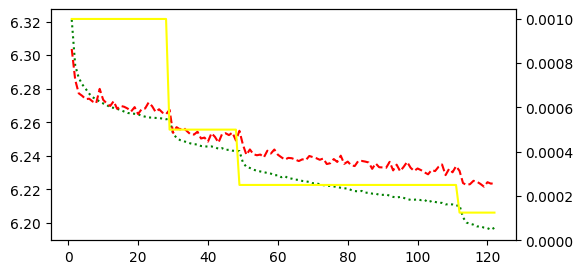

In [22]:
plt.plot(history.epoch, history.train_loss, "g:", label="Train Loss")
plt.plot(history.epoch, history.test_loss, "r--", label="Test Loss")
ax2 = plt.twinx()
ax2.plot(history.epoch, history.lr, c="yellow", label="Learning Rate")
ax2.set_ylim(0, ax2.get_ylim()[1])

In [23]:
# model = NeuralNetwork()
d = next(iter(test_dataloader))[0]
pred = predict(d, model)
res = pd.DataFrame({
    "target":next(iter(test_dataloader))[1].flatten().cpu(), 
    "pred":pred
})
res["err"] = np.abs(res["target"] - res["pred"])
res

,target,pred,err
0,17.809868,-3.902651,21.712519
1,-4.199743,0.354000,4.553743
2,-4.630089,0.329528,4.959617
3,-0.990033,0.290855,1.280888
4,5.019903,-0.490338,5.510242
...,...,...,...
2043,10.459423,2.265569,8.193853
2044,-5.779862,-0.236730,5.543132
2045,1.399517,-0.903289,2.302806
2046,-6.260276,-0.246168,6.014108


(-25.547962188720703, 22.810546875)

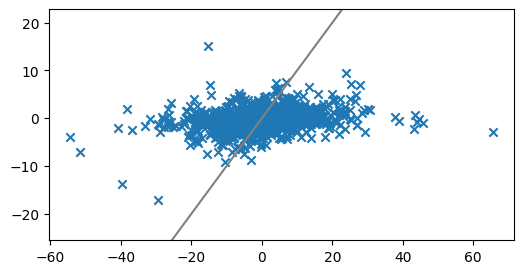

In [24]:
plt.plot([res.target.min(), res.target.max()], [res.target.min(), res.target.max()], color="gray")
plt.scatter(res.target, res.pred, marker="x")
plt.ylim(res.pred.min()*1.5,res.pred.max()*1.5)

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,   0.,   2.,   3.,   5.,   6.,   6.,  18.,  19.,  30.,
         53., 107., 229., 413., 519., 298., 144.,  84.,  45.,  15.,  19.,
         11.,   7.,   2.,   2.,   3.,   2.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-17.03197479, -16.38719559, -15.74241447, -15.09763432,
        -14.45285416, -13.808074  , -13.16329384, -12.51851368,
        -11.87373352, -11.22895336, -10.5841732 ,  -9.93939304,
         -9.29461288,  -8.64983368,  -8.00505352,  -7.36027288,
         -6.71549273,  -6.07071257,  -5.42593241,  -4.78115273,
         -4.13637257,  -3.49159217,  -2.84681225,  -2.20203209,
         -1.55725193,  -0.91247177,  -0.26769164,   0.37708846,
          1.02186859,   1.66664875,   2.31142879,   2.95620894,
          3.6009891 ,   4.24576902,   4.89054918,   5.53532934,
          6.1801095 ,   6.82488966,   7.46966982,   8.1144495 ,
          8.759229

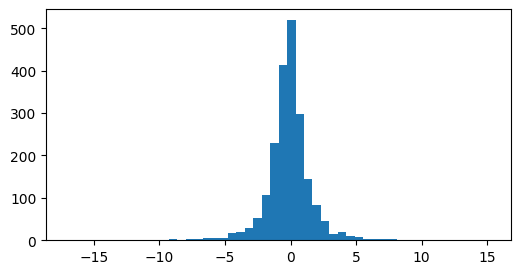

In [25]:
plt.hist(res["pred"], bins=50)

# Submission

In [26]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [27]:
full_submission_data = df_raw.iloc[0:0,:]
full_prediction_data = pd.DataFrame([], columns=[""])
full_submission_data

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id


In [28]:
for (raw_df_test, _, sample_prediction) in iter_test: 
    
    full_submission_data = pd.concat((full_submission_data,raw_df_test), axis=0)

    df_test = add_info_columns(full_submission_data)
    x_test = df_test.loc[:,x_cols].iloc[-200:,:]
    x_test_normalized = normalize_features(x_test).fillna(0.0).values
    
    pred = predict(torch.Tensor(x_test_normalized).to(device), model)
    
    sample_prediction['target'] = pred
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [29]:
sample_prediction

,row_id,target
0,480_540_0,-0.007749
1,480_540_1,-1.916079
2,480_540_2,-1.466806
3,480_540_3,-1.190565
4,480_540_4,-0.860567
...,...,...
195,480_540_195,-1.528247
196,480_540_196,-1.074312
197,480_540_197,0.548742
198,480_540_198,0.224574


(array([ 4.,  0.,  1.,  2.,  6.,  2.,  7.,  9.,  6., 20., 40., 43., 25.,
        14.,  9.,  7.,  0.,  3.,  0.,  2.]),
 array([-4.37479353, -3.98693371, -3.59907365, -3.21121359, -2.82335377,
        -2.43549395, -2.04763389, -1.65977395, -1.27191401, -0.88405406,
        -0.49619412, -0.10833418,  0.27952576,  0.6673857 ,  1.05524564,
         1.44310558,  1.83096552,  2.21882534,  2.6066854 ,  2.99454546,
         3.38240528]),
 <BarContainer object of 20 artists>)

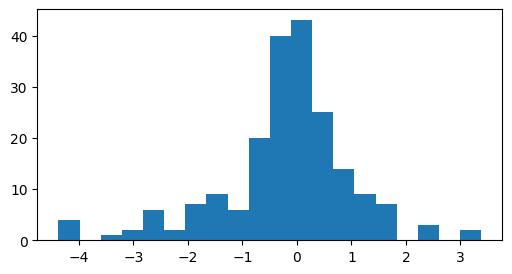

In [30]:
plt.hist(sample_prediction["target"], bins=20)